# Convolutional Autoencoder for Preprocessed GridSat-B1

In this notebook, we tested the **Convolutional Autoencoder** with the preprocessed data. The major architecture is learning from the [Tensorflow Core](https://www.tensorflow.org/tutorials/generative/cvae).

First we implement the utility functions for data IO.

In [1]:
import numpy as np
import pandas as pd
import os, argparse, logging, csv, h5py
import tensorflow as tf

# Utility functions
def list_prerpocessed_gridsatb1_files(dir, suffix='.npy', to_remove=['.npy']):
    ''' To scan through the sapecified dir and get the corresponding file with suffix. '''
    import os
    import pandas as pd
    xfiles = []
    for root, dirs, files in os.walk(dir, followlinks=True):  # Loop through the directory
        for fn in files:
            if fn.endswith(suffix):         # Filter files with suffix
                timestamp = fn
                for s in to_remove:         # Removing prefix and suffix to get time-stamp
                    timestamp = timestamp.replace(s,'')
                xfiles.append({'timestamp':timestamp, 'xuri':os.path.join(root, fn)})
    return(pd.DataFrame(xfiles).sort_values('timestamp').reset_index(drop=True))

# Binary reader
def read_prerpocessed_gridsatb1(furi):
    import numpy as np
    return(np.load(furi))

def read_multiple_prerpocessed_noaagridsatb1(flist, flatten=False):
    ''' This method reads in a list of NOAA-GridSat-B1 images and returns a numpy array. '''
    import numpy as np
    data = []
    for f in flist:
        tmp = np.load(f)
        if flatten:
            tmp = tmp.flatten()
        data.append(np.expand_dims(tmp,-1))
    return(np.array(data))

def data_generator_ae(flist, batch_size, rseed=0):
    ''' Data generator for batched processing. '''
    nSample = len(flist)
    # Shuffle file list if specified
    if rseed!=0:
        flist = flist.sample(frac=1, random_state=rseed).reset_index(drop=True)
        logging.info('Shuffling the input data for batch processing with random seed: '+str(rseed))
    # This line is just to make the generator infinite, keras needs that    
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < nSample:
            limit = min(batch_end, nSample)
            X = read_multiple_prerpocessed_noaagridsatb1(flist['xuri'].iloc[batch_start:limit])
            #print(X.shape)
            yield (X,X) # a tuple with two numpy arrays with batch_size samples     
            batch_start += batch_size   
            batch_end += batch_size

In [2]:
# Load some data
datadir = 'D:/worksapce/noaa/256/'
datainfo = list_prerpocessed_gridsatb1_files(datadir)
print(datainfo.shape)
print(datainfo.head())

samples = datainfo.sample(10, random_state=101).sort_values('timestamp').reset_index(drop=True)
print(samples)
x = read_multiple_prerpocessed_noaagridsatb1(samples['xuri'])

(2178, 2)
    timestamp                                  xuri
0  2013.01.01  D:/worksapce/noaa/256/2013.01.01.npy
1  2013.01.02  D:/worksapce/noaa/256/2013.01.02.npy
2  2013.01.03  D:/worksapce/noaa/256/2013.01.03.npy
3  2013.01.04  D:/worksapce/noaa/256/2013.01.04.npy
4  2013.01.05  D:/worksapce/noaa/256/2013.01.05.npy
    timestamp                                  xuri
0  2013.01.20  D:/worksapce/noaa/256/2013.01.20.npy
1  2013.08.25  D:/worksapce/noaa/256/2013.08.25.npy
2  2013.11.22  D:/worksapce/noaa/256/2013.11.22.npy
3  2014.01.17  D:/worksapce/noaa/256/2014.01.17.npy
4  2014.05.17  D:/worksapce/noaa/256/2014.05.17.npy
5  2015.04.15  D:/worksapce/noaa/256/2015.04.15.npy
6  2016.10.09  D:/worksapce/noaa/256/2016.10.09.npy
7  2017.07.27  D:/worksapce/noaa/256/2017.07.27.npy
8  2018.01.02  D:/worksapce/noaa/256/2018.01.02.npy
9  2018.04.14  D:/worksapce/noaa/256/2018.04.14.npy


## The architecture of AE and CAE

We want to reduce the dimention from (256,256) or (512,512) to (2048,). To precisely change the dimension, we need to design our AE carefully to get the desired latent space. 

If every time we shrink the domain in half, we double the number of kernels, then we will have: 

(256,256,1) -> (128,128,16) -> (64,64,32) -> (32,32,64) -> (16,16,128) -> (8,8,256) -> (4,4,512) -> (2,2,1024) -> (1,1,2048)


Variational AE is more convenient, because we can simply force the latent space to have 1024 Gaussian distributions:

(256,256,1) -> (128,128,32) -> (64,64,64) -> (32,32,128) -> (16,16,256) -> (1024+1024,)

In [3]:
class CAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, inputx, inputy):
    super(CAE, self).__init__()
    self.inputx = inputx
    self.inputy = inputy
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(inputx, inputy, 1), name='encoder_input'),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), padding='same',
                activation='relu', name='encoder_conv1'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='same', 
                activation='relu', name='encoder_conv2'),
            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), padding='same', 
                activation='relu', name='encoder_conv3'),
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2, 2), padding='same', 
                activation='relu', name='encoder_conv4'),
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2, 2), padding='same', 
                activation='relu', name='encoder_conv5'),
            tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2, 2), padding='same', 
                activation='relu', name='encoder_conv6'),
            tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=(2, 2), padding='same', 
                activation='relu', name='encoder_conv7'),
            tf.keras.layers.Conv2D(filters=2048, kernel_size=3, strides=(2, 2), padding='same', 
                activation='relu', name='encoder_conv8'),
        ], name='encoder'
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(1,1,2048)),
            tf.keras.layers.Conv2DTranspose(filters=1024, kernel_size=3, strides=2, padding='same',
                activation='relu', name='decoder_conv1'),
            tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same',
                activation='relu', name='decoder_conv2'),
            tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same',
                activation='relu', name='decoder_conv3'),
            tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',
                activation='relu', name='decoder_conv4'),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu', name='decoder_conv5'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu', name='decoder_conv6'),
            tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same',
                activation='relu', name='decoder_conv7'),
            tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',
                activation='relu', name='decoder_conv8'),
            # No activation
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', 
                activation='sigmoid', name='decoder_outoput'),
        ], name='decoder'
    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [4]:
cae = CAE(inputx=256, inputy=256)
cae.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['cosine_similarity'])
cae.build(input_shape=(1,256,256,1))
cae.encoder.summary()
cae.decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_conv1 (Conv2D)       (None, 128, 128, 32)      320       
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 64, 64, 64)        18496     
_________________________________________________________________
encoder_conv3 (Conv2D)       (None, 32, 32, 128)       73856     
_________________________________________________________________
encoder_conv4 (Conv2D)       (None, 16, 16, 256)       295168    
_________________________________________________________________
encoder_conv5 (Conv2D)       (None, 8, 8, 256)         590080    
_________________________________________________________________
encoder_conv6 (Conv2D)       (None, 4, 4, 512)         1180160   
_________________________________________________________________
encoder_conv7 (Conv2D)       (None, 2, 2, 1024)        4719

In [5]:
# test
batch_size=16
cae = CAE(inputx=256, inputy=256)
cae.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['cosine_similarity'])
dg = data_generator_ae(datainfo, batch_size)
cae.fit(dg, epochs=5, steps_per_epoch=np.ceil(datainfo.shape[0]/batch_size))

Epoch 1/5
137/137 [==============================] - 35s 251ms/step - loss: 0.0113 - cosine_similarity: 1.0000
Epoch 2/5
137/137 [==============================] - 10s 76ms/step - loss: 0.0067 - cosine_similarity: 1.0000
Epoch 3/5
137/137 [==============================] - 10s 76ms/step - loss: 0.0066 - cosine_similarity: 1.0000
Epoch 4/5
137/137 [==============================] - 10s 76ms/step - loss: 0.0065 - cosine_similarity: 1.0000
Epoch 5/5
137/137 [==============================] - 10s 76ms/step - loss: 0.0065 - cosine_similarity: 1.0000


(10, 256, 256, 1)
(10, 256, 256, 1)


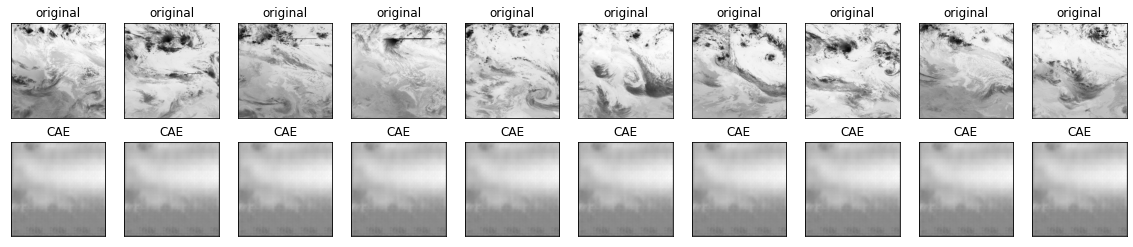

In [6]:
xcae = cae(x)
print(x.shape)
print(xcae.shape)

# Test plot
%matplotlib inline
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i,:,:,0])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(xcae[i,:,:,0])
    plt.title("CAE")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Epoch 1/5
35/35 [==============================] - 4s 84ms/step - loss: 0.0177 - cosine_similarity: 1.0000
Epoch 2/5
35/35 [==============================] - 3s 83ms/step - loss: 0.0057 - cosine_similarity: 1.0000
Epoch 3/5
35/35 [==============================] - 3s 80ms/step - loss: 0.0051 - cosine_similarity: 1.0000
Epoch 4/5
35/35 [==============================] - 3s 83ms/step - loss: 0.0043 - cosine_similarity: 1.0000
Epoch 5/5
35/35 [==============================] - 3s 82ms/step - loss: 0.0025 - cosine_similarity: 1.0000
Model: "CAE2_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_conv1 (Conv2D)       (None, 128, 128, 16)      160       
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 64, 64, 32)        4640      
Total params: 4,800
Trainable params: 4,800
Non-trainable params: 0
_____________________________________________

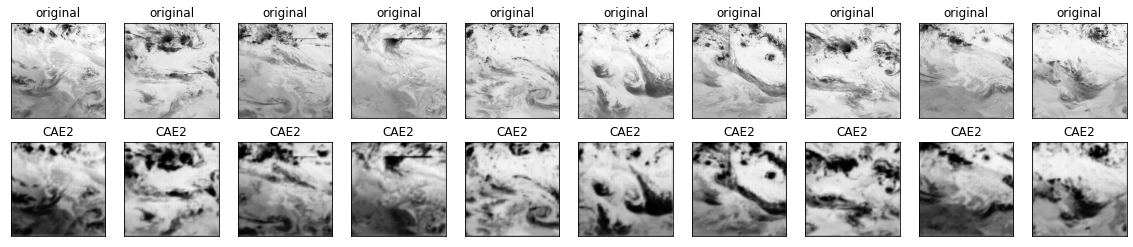

In [7]:
# A shallower CAE
class CAE2(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, inputx, inputy):
        super(CAE2, self).__init__()
        self.inputx = inputx
        self.inputy = inputy
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(inputx, inputy, 1), name='encoder_input'),
                tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2, 2), padding='same',
                    activation='relu', name='encoder_conv1'),
                tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), padding='same', 
                    activation='relu', name='encoder_conv2'),
            ], name='CAE2_encoder'
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu', name='decoder_conv7'),
                tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same',
                    activation='relu', name='decoder_conv8'),
                # No activation
                tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', 
                    activation='sigmoid', name='decoder_outoput'),
            ], name='CAE2_decoder'
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# test
batch_size=64
cae2 = CAE2(inputx=256, inputy=256)
cae2.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['cosine_similarity'])
dg = data_generator_ae(datainfo, batch_size)
hist = cae2.fit(dg, epochs=5, steps_per_epoch=np.ceil(datainfo.shape[0]/batch_size))

cae2.encoder.summary()
cae2.decoder.summary()

# 
xcae2 = cae2(x)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i,:,:,0])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(xcae2[i,:,:,0])
    plt.title("CAE2")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

We tested several CAEs of different depths, and found that the deeper the AE(data is further reduced) is, the more blurry the de-compressed images are. This is reasonable since we compress the data more.

## Reduce the number of filters instead of domain-size

We saw that reducing the domain-size to 1 gave very bad results (10 images are almost identical after decompression). Here we test a different approach:

1. In the **encoder**, the final layer reduces the filter number instead of domain-size.
2. In the **decoder**, use more filters to enable detailed decompression.

Epoch 1/5
137/137 [==============================] - 43s 294ms/step - loss: 0.0072 - cosine_similarity: 1.0000
Epoch 2/5
137/137 [==============================] - 39s 285ms/step - loss: 0.0020 - cosine_similarity: 1.0000
Epoch 3/5
137/137 [==============================] - 39s 286ms/step - loss: 0.0015 - cosine_similarity: 1.0000
Epoch 4/5
137/137 [==============================] - 39s 288ms/step - loss: 0.0014 - cosine_similarity: 1.0000
Epoch 5/5
137/137 [==============================] - 39s 286ms/step - loss: 0.0012 - cosine_similarity: 1.0000
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_conv1 (Conv2D)       (None, 128, 128, 128)     1280      
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 64, 64, 256)       295168    
_________________________________________________________________
encoder_conv3 (Conv2D)       (No

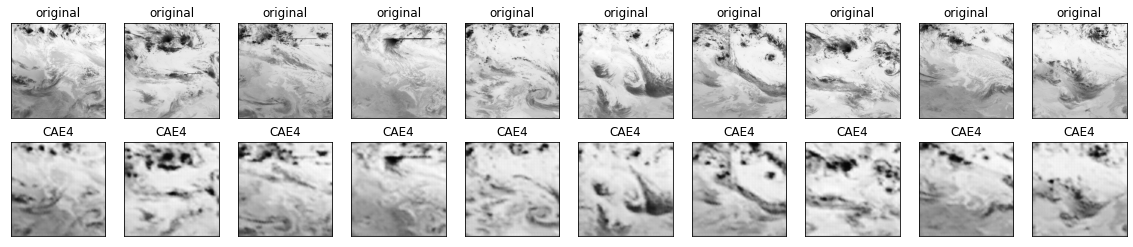

In [8]:
class CAE4(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, inputx, inputy):
        super(CAE4, self).__init__()
        self.inputx = inputx
        self.inputy = inputy
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(inputx, inputy, 1), name='encoder_input'),
                tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), padding='same',
                    activation='relu', name='encoder_conv1'),
                tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2, 2), padding='same', 
                    activation='relu', name='encoder_conv2'),
                tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2, 2), padding='same', 
                    activation='relu', name='encoder_conv3'),
                tf.keras.layers.Conv2D(filters=2, kernel_size=3, strides=(1, 1), padding='same', 
                    activation='relu', name='encoder_conv4'),
            ], name='encoder'
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(32,32,2)),
                tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same',
                    activation='relu', name='decoder_conv1'),
                tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same',
                    activation='relu', name='decoder_conv2'),
                tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',
                    activation='relu', name='decoder_conv3'),
                # No activation
                tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', 
                    activation='sigmoid', name='decoder_outoput'),
            ], name='decoder'
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# test
batch_size=16
cae4 = CAE4(inputx=256, inputy=256)
cae4.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['cosine_similarity'])
dg = data_generator_ae(datainfo, batch_size)
cae4.fit(dg, epochs=5, steps_per_epoch=np.ceil(datainfo.shape[0]/batch_size))

cae4.encoder.summary()
cae4.decoder.summary()

# 
xcae4 = cae4(x)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i,:,:,0])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(xcae4[i,:,:,0])
    plt.title("CAE4")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

The *reducing-filter-number* approach seemed work well. And then we want to further explore using **Gaussian mixtures** to represent the latent space.

The CVAE is tested in [the next notebook]('./07_CVAE_for_preprocessed_data.ipynb').
